In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
import pyspark
import pandas as pd


pd.set_option('max_columns', None)

import numpy as np
import pandas as pd
import seaborn as sns
import os, re, joblib
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
sc = pyspark.SparkContext(appName = "cc_approval")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/19 00:16:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
sc

<SparkContext master=local[*] appName=cc_approval>

In [4]:
spark  = SparkSession.builder.appName('cc_approval').getOrCreate()
spark

In [5]:
ls

README.md                  dataset/
credit_card_pyspark.ipynb


In [6]:
cc_df = spark.read.csv("dataset/application_record.csv", header=True)
st_df = spark.read.csv("dataset/credit_record.csv", header=True)

In [7]:
cc_df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: string (nullable = true)
 |-- AMT_INCOME_TOTAL: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- DAYS_BIRTH: string (nullable = true)
 |-- DAYS_EMPLOYED: string (nullable = true)
 |-- FLAG_MOBIL: string (nullable = true)
 |-- FLAG_WORK_PHONE: string (nullable = true)
 |-- FLAG_PHONE: string (nullable = true)
 |-- FLAG_EMAIL: string (nullable = true)
 |-- OCCUPATION_TYPE: string (nullable = true)
 |-- CNT_FAM_MEMBERS: string (nullable = true)



In [8]:
len(cc_df.columns)

18

In [9]:
cc_df.columns

['ID',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'FLAG_MOBIL',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS']

In [10]:
cc_df.select("CODE_GENDER").show(5)

+-----------+
|CODE_GENDER|
+-----------+
|          M|
|          M|
|          M|
|          F|
|          F|
+-----------+
only showing top 5 rows



In [11]:
cc_df.select([i for i in cc_df.columns[:5]]).show(5)

+-------+-----------+------------+---------------+------------+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|
+-------+-----------+------------+---------------+------------+
|5008804|          M|           Y|              Y|           0|
|5008805|          M|           Y|              Y|           0|
|5008806|          M|           Y|              Y|           0|
|5008808|          F|           N|              Y|           0|
|5008809|          F|           N|              Y|           0|
+-------+-----------+------------+---------------+------------+
only showing top 5 rows



In [12]:
cc_df_pd = cc_df.toPandas()
st_df_pd = st_df.toPandas()
cc_df_pd.head()

23/06/19 00:16:15 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,None,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,None,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


# Univariate Analysis

In [13]:
[(len(cc_df_pd[i].unique()),i) for i in cc_df_pd.columns if len(cc_df_pd[i].unique()) == 2]

[(2, 'CODE_GENDER'),
 (2, 'FLAG_OWN_CAR'),
 (2, 'FLAG_OWN_REALTY'),
 (2, 'FLAG_WORK_PHONE'),
 (2, 'FLAG_PHONE'),
 (2, 'FLAG_EMAIL')]

In [14]:
def value_cnt_norm_cal(df,feature):
    feature_value_cnt = df[feature].value_counts()
    feature_value_cnt_norm = df[feature].value_counts(normalize = True) * 100
    feature_value_cnt_combine = pd.concat([feature_value_cnt,feature_value_cnt_norm], axis = 1)
    feature_value_cnt_combine.columns = ['COUNT','FREQUENCY']
    return feature_value_cnt_combine

In [15]:
value_cnt_norm_cal(cc_df_pd,'CODE_GENDER')

,COUNT,FREQUENCY
F,294440,67.138365
M,144117,32.861635


In [16]:
def create_bar_plot(df,feature):
    fig, ax = plt.subplots(figsize=(6,10))
    sns.barplot(x=value_cnt_norm_cal(df,feature).index,\
                y=value_cnt_norm_cal(df,feature).values[:,0])
    ax.set_xticklabels(labels=value_cnt_norm_cal(df,feature).index,rotation=90,ha='right')
            
    plt.xlabel(f'{feature}')
    plt.ylabel('Count')
    plt.title(f'{feature} count')
    return plt.show()  

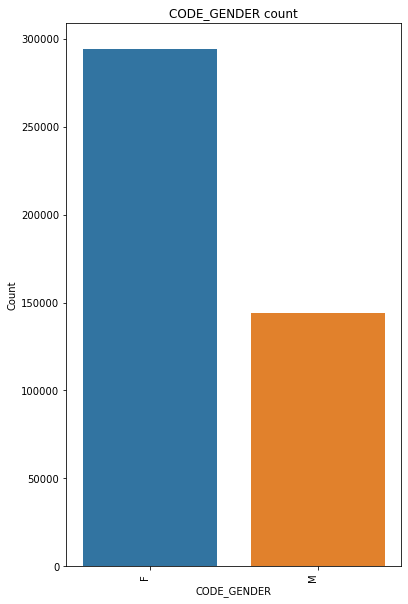

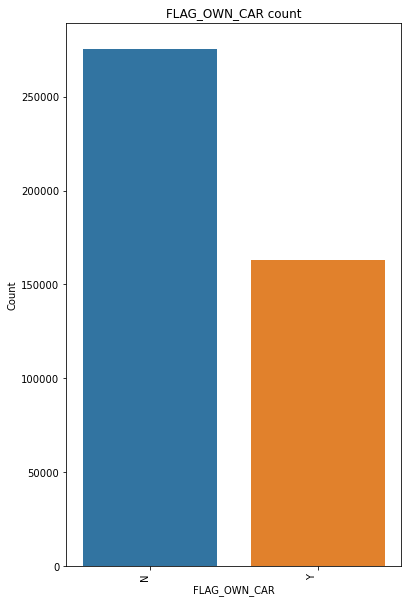

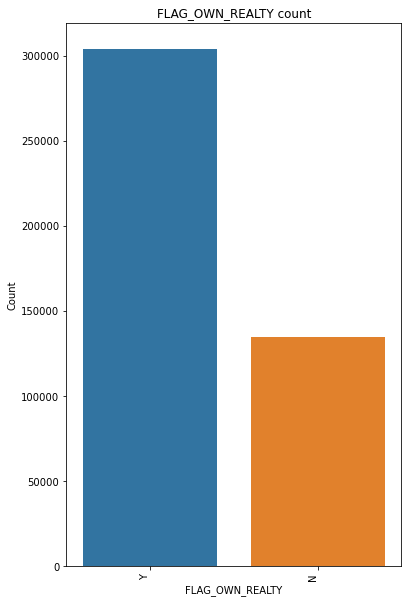

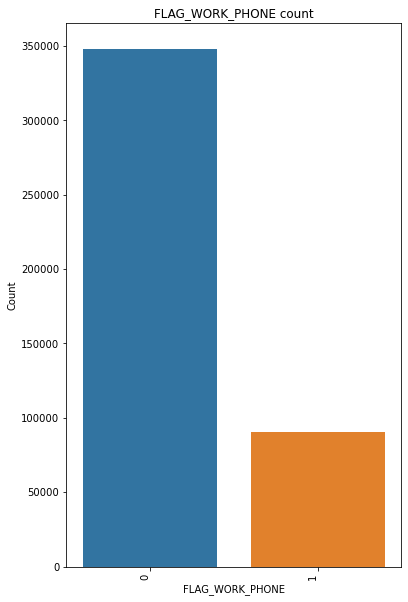

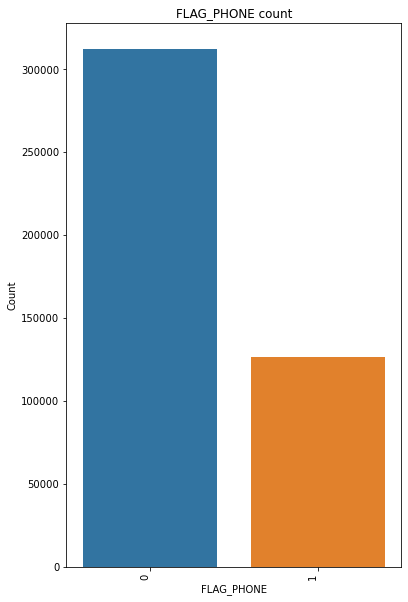

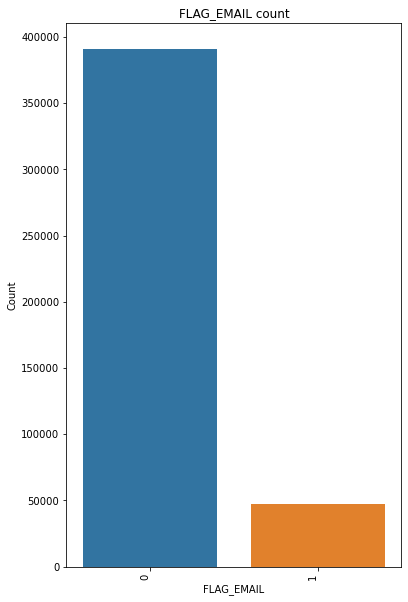

[None, None, None, None, None, None]

In [17]:
[create_bar_plot(cc_df_pd,i) for i in cc_df_pd.columns if len(cc_df_pd[i].unique()) == 2]